# Combining Astrometry and Radial Velocity for Exoplanet Detection

## Authors

Nicolas Unger (DACE Data Scientist)

Jean-Baptiste Delisle (DACE Data Scientist)

## Requirements

Anaconda 3, Python 3.8 or later, IPython 7.8.0<br>

**`dace-query`** : 1.2.0 or later

**`kepmodel`** : 1.0.7 or later

**`spleaf`** : 2.1.12 or later

## Introduction

In this tutorial, we will demonstrate how to fit astrometric and radial velocity (RV) orbits using Hipparcos data. We will use the `dace-query` and `kepmodel` packages to access and analyze the data. The target star for this tutorial is HD 17289, replicating the analysis that was done in [Delisle et al. 2022](https://ui.adsabs.harvard.edu/abs/2022A%26A...667A.172D/abstract). By the end of this tutorial, you will learn how to:

1. Retrieve relevant data using the DACE API.
2. Perform a joint analysis of astrometry and RV data.
3. Identify potential companions using periodograms.
4. Visualize the fitted orbits and residuals.

Let's get started!

## 0. Imports and Setup

First, we need to import the necessary libraries and set up some constants and parameters. This includes defining astronomical constants, target star information, and observational parameters. We will also configure the instruments and analysis settings.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dace_query.astrometry import Astrometry
from dace_query.spectroscopy import Spectroscopy
from kepmodel import astro, astrorv, rv
from spleaf import term
from copy import deepcopy

In [54]:
# Define target star and observational parameters
target = "HD 17289"  # Target star name
amp = "as"  # Amplitude (semi-major axis of the star)
ms = 1.01  # Stellar mass in solar masses
phase = "Marg0"  # Phase of analysis
epoch_rjd = 50_000  # Reduced Julian Date epoch
epoch_bjd = 2_400_000  # Barycentric Julian Date epoch

# Defaults
default_hip_jitter = 0.0  # Default HIPPARCOS jitter value
# Default instrument jitter value
default_inst_jitter = {
    "CORALIE98": 5.0,
    "CORALIE07": 8.0,
}
# Default instrument colors for plotting
default_inst_color = {
    "CORALIE98": "deepskyblue",
    "CORALIE07": "darkviolet",
}

## 1. Getting the Data


### CORALIE RV Data

We will start by retrieving the radial velocity (RV) data for our target star, HD 17289, using the `dace-query` package. We will filter the data to include only observations from the CORALIE98 and CORALIE07 instruments.

In [55]:
rv_data = (
    Spectroscopy.query_database(
        filters={
            # Filter by object name for HD17289
            "obj_id_catname": {"contains": ["HD17289"]},
            # Filter by instrument name to use only the data from CORALIE98 and CORALIE07
            "ins_name": {"contains": ["CORALIE98", "CORALIE07"]},
            # Filter only the data with well behaved uncertainties
            "spectro_ccf_rv_err": {"max": 50},
        },
        output_format="pandas",
    )
    # Sort the data by date
    .sort_values("obj_date_bjd")
    # Reset the index
    .reset_index(drop=True)
)

# Get the list of instruments
instruments = rv_data["ins_name"].unique()

In [56]:
rv_data.head()

,obj_id_catname,obj_pos_coordinates_hms_dms,ins_name,prog_id,obj_date_bjd,date_night,ins_drs_version,pub_bibcode,pub_ref,ins_mode,...,ins1_adc2_temp,ins2_adc1_temp,ins2_adc2_temp,ins3_adc1_temp,ins3_adc2_temp,ins4_adc1_temp,ins4_adc2_temp,th_ar,th_ar1,th_ar2
0,HD17289,02:43:35.5 / -62:55:08.8,CORALIE98,703,51128.699883,1998-11-10,3.3,,,CORALIE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HD17289,02:43:35.5 / -62:55:08.8,CORALIE98,703,51410.916661,1999-08-19,3.3,,,CORALIE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HD17289,02:43:35.5 / -62:55:08.8,CORALIE98,703,51814.792299,2000-09-26,3.3,,,CORALIE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HD17289,02:43:35.5 / -62:55:08.8,CORALIE98,703,51814.804000,2000-09-26,3.3,,,CORALIE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HD17289,02:43:35.5 / -62:55:08.8,CORALIE98,703,51901.658240,2000-12-22,3.3,,,CORALIE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Hipparcos Astrometry Data

Next, we will retrieve the astrometric data from the Hipparcos mission. We will bin the astrometric measurements by 1-day intervals to reduce noise and compute weighted averages within each bin.

In [57]:
# astrometry_data = Astrometry.get_hipparcos_timeseries(
#     "HD17289", output_format="pandas"
# )

In [58]:
# Import the necessary modules to directly access Hipparcos data
import requests
import pandas as pd
from io import StringIO

# Directly request Hipparcos data for HIP 12726
hip_id = "12726"
url = f"https://vizier.cds.unistra.fr/viz-bin/asu-tsv?-source=I/239/hip_main&HIP={hip_id}"

response = requests.get(url)
data = pd.read_csv(StringIO(response.text), sep='\t', comment='#')
# print(data)
data.columns


Index(['HIP', 'RAhms', 'DEdms', 'Vmag', 'RAICRS', 'DEICRS', 'Plx', 'pmRA',
       'pmDE', 'e_Plx', 'B-V', 'Notes', '_RA.icrs', '_DE.icrs'],
      dtype='object')

In [59]:
import pandas as pd
import numpy as np
import os

# Function to parse the IAD file for HIP 12996
def parse_hip_iad_file(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    # Print first few lines to understand the structure
    print("First few lines of the file:")
    for i in range(min(15, len(lines))):
        print(f"Line {i+1}: {lines[i].strip()}")
    
    # Find where the actual data begins
    data_start_line = 0
    for i, line in enumerate(lines):
        if "IORB" in line and "EPOCH" in line and "PARF" in line:
            data_start_line = i + 1
            break
    
    print(f"Data appears to start at line {data_start_line}")
    
    # Extract metadata if possible from the header
    hip_id = 12726  # We know this is for HIP 12996
    
    # Extract residual records
    data_rows = []
    for i in range(data_start_line, len(lines)):
        line = lines[i].strip()
        if not line or line.startswith('#'):
            continue  # Skip empty lines or comments
        
        # Split the line by whitespace (assuming space or tab delimited)
        fields = line.split()
        
        # Skip if not enough fields
        if len(fields) < 7:
            print(f"Skipping line {i+1}: insufficient fields - {line}")
            continue
        
        try:
            # Try to parse the fields
            iorb = int(fields[0])
            epoch = float(fields[1])
            parf = float(fields[2])
            cpsi = float(fields[3])
            spsi = float(fields[4])
            res = float(fields[5])
            sres = float(fields[6])
            
            # Calculate additional parameters
            t_bjd = 2448349.0 + (epoch * 365.25)
            s_mas = res  # Placeholder
            cth = spsi
            sth = -cpsi
            iad_source = "JavaTool"
            
            # Create data row
            data_row = {
                'HIP': hip_id,
                'IORB': iorb,
                'EPOCH': epoch,
                'PARF': parf,
                'CPSI': cpsi,
                'SPSI': spsi,
                'RES': res,
                'SRES': sres,
                'T_BJD': t_bjd,
                'S_MAS': s_mas,
                'CTH': cth,
                'STH': sth,
                'IAD_SOURCE': iad_source
            }
            data_rows.append(data_row)
        except Exception as e:
            print(f"Error parsing line {i+1}: {str(e)} - {line}")
    
    # Create DataFrame with all data
    df = pd.DataFrame(data_rows)
    return df

# Path to the IAD file in the current directory
iad_filepath = "H012726.d"

# Parse the file and create the DataFrame
try:
    astrometry_data = parse_hip_iad_file(iad_filepath)
    
    if len(astrometry_data) > 0:
        # Display basic information
        print(f"\nSuccessfully parsed data for HIP {astrometry_data['HIP'].iloc[0]}")
        print(f"Number of observations: {len(astrometry_data)}")
        
        # Display the first few rows
        print("\nFirst 5 rows of data:")
        print(astrometry_data.head())
        
        # Display data statistics
        print("\nBasic statistics:")
        print(astrometry_data.describe())
        
        # Save to CSV if needed
        # astrometry_data.to_csv("hip12996_astrometry_data.csv", index=False)
        # print("\nData saved to hip12996_astrometry_data.csv")
    else:
        print("No valid data rows were parsed from the file.")
    
except Exception as e:
    print(f"Error parsing file: {str(e)}")
    import traceback
    traceback.print_exc()

First few lines of the file:
Line 1: # This file contains residual records, extracted from the Hipparcos 2
Line 2: # Interactive Data Access Tool (2014). For more information, see:
Line 3: # https://www.cosmos.esa.int/web/hipparcos/interactive-data-access
Line 4: # https://www.cosmos.esa.int/web/hipparcos/catalogues
Line 5: #
Line 6: # HIP    MCE    NRES NC isol_n SCE  F2     F1
Line 7: # 12726  12693  113  1  1      0    1.00   0
Line 8: # Hp      B-V    VarAnn NOB NR
Line 9: # 7.5638  0.588  0      113 0
Line 10: # RAdeg        DEdeg        Plx      pm_RA    pm_DE    e_RA   e_DE   e_Plx  e_pmRA e_pmDE dpmRA  dpmDE  e_dpmRA  e_dpmDE  ddpmRA  ddpmDE  e_ddpmRA  e_ddpmDE  upsRA   upsDE   e_upsRA  e_upsDE  var
Line 11: # 40.89793039  -62.91910914 20.80    -26.19   -36.25   1.06   1.07   1.20   1.18   1.30   ---    ---    ---      ---      ---     ---     ---       ---       ---     ---     ---      ---      0.26
Line 12: #
Line 13: # IORB   EPOCH    PARF    CPSI    SPSI     RES   SRES
Lin

In [60]:
astrometry_data

,HIP,IORB,EPOCH,PARF,CPSI,SPSI,RES,SRES,T_BJD,S_MAS,CTH,STH,IAD_SOURCE
0,12726,77,-1.3126,-0.6708,-0.2584,0.9660,1.95,7.14,2.447870e+06,1.95,0.9660,0.2584,JavaTool
1,12726,77,-1.3126,-0.6705,-0.2588,0.9659,-5.98,7.27,2.447870e+06,-5.98,0.9659,0.2588,JavaTool
2,12726,77,-1.3126,-0.6715,-0.2574,0.9663,-2.07,7.02,2.447870e+06,-2.07,0.9663,0.2574,JavaTool
3,12726,77,-1.3126,-0.6712,-0.2578,0.9662,-2.61,7.12,2.447870e+06,-2.61,0.9662,0.2578,JavaTool
4,12726,129,-1.2493,0.6570,-0.9788,0.2048,-7.48,6.94,2.447893e+06,-7.48,0.2048,0.9788,JavaTool
...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,12726,2521,1.6568,-0.6726,-0.4346,0.9006,-12.12,8.68,2.448954e+06,-12.12,0.9006,0.4346,JavaTool
109,12726,2667,1.8340,0.6098,-0.7155,0.6986,-13.77,7.29,2.449019e+06,-13.77,0.6986,0.7155,JavaTool
110,12726,2667,1.8340,0.6101,-0.7159,0.6982,-15.56,7.53,2.449019e+06,-15.56,0.6982,0.7159,JavaTool
111,12726,2747,1.9311,-0.5815,0.9449,0.3273,11.27,7.26,2.449054e+06,11.27,0.3273,-0.9449,JavaTool


The first columns are the original ones from the 2007 reduction by van Leeuwen. Here is an explanation for each parameter:

- IORB (-): Orbit number.
- EPOCH (years): Observation epoch, given as Year - 1991.25.
- PARF (-): Parallax factor.
- CPSI (-): Cosine of Psi.
- SPSI (-): Sine of Psi.
- RES (mas): Abscissa residual.
- SRES (mas): Formal error on abscissa residual.

Then the new columns identify the target, add the timeseries of the absolute astrometry (the original residuals with the 5, 7, or 9 parameter model added back in), the scan angle in the Gaia convention and the source of the original Intermediate Astrometric Data.

- HIP (-): Hipparcos identifier.
- T_BJD (days): Epoch in Barycentric Julian Date (BJD).
- S_MAS (mas): Absolute astrometric signal, RES + fitted model.
- CTH (-): Cosine of the theta angle, following Gaia convention.
- STH (-): Sine of the theta angle, following Gaia convention.
- IAD_SOURCE (-): Indicates the source of the IAD, either "Brandt2021" or "JavaTool".

Here is a digram explaining the different scan angle conventions between Hipparcos and Gaia:

![image](scan_angle_convention.png)

In [61]:
# Bin astrometric measurements by 1-day intervals to reduce noise
astrometry_data["bin"] = (astrometry_data["T_BJD"] // 1).astype(int)

# Compute weighted averages within each bin
w = 1 / astrometry_data["SRES"] ** 2
astro_data = (
    astrometry_data.groupby("bin")
    .apply(
        lambda x: pd.Series(
            {
                col: np.average(x[col], weights=w.loc[x.index])
                for col in x.columns
                if (col != "SRES") and (col != "IAD_SOURCE")
            }
            | {"SRES": np.sqrt(1 / np.sum(w.loc[x.index]))}
        )
    )
    .reset_index(drop=True)
)

/var/folders/cb/dq7rbdjs1gbbgm7jgswln58m0000gn/T/ipykernel_46540/352488831.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


## 2. Initialize the Models

In this step, we will initialize the models for the astrometry, RV, and joint astrometry+RV analyses. We will start by fitting only the linear parameters of each model before adding any Keplerian parameters.

### Astrometry

We will initialize the astrometric model and fit the linear parameters, including parallax, position, and proper motion.

In [62]:
# Initialize astrometric model
astro_model = astro.AstroModel(
    astro_data["T_BJD"].values - epoch_bjd,
    astro_data["S_MAS"].values,
    astro_data["CTH"].values,
    astro_data["STH"].values,
    err=term.Error(astro_data["SRES"].values),
    jit=term.Jitter(default_hip_jitter),  # Set default jitter
)

# Fit linear parameters to astrometric data
dt_yr = (astro_data["T_BJD"] - epoch_bjd) / 365.25  # Convert time to years
# Add basic astrometric parameters (parallax, position, proper motion)
astro_model.add_lin(astro_data["PARF"], "plx")
astro_model.add_lin(astro_data["CTH"], "delta")
astro_model.add_lin(astro_data["STH"], "alpha")
astro_model.add_lin(dt_yr * astro_data["CTH"], "mud")
astro_model.add_lin(dt_yr * astro_data["STH"], "mua")

# Fit the astrometric model to the data and show the parameters
astro_model.fit()
astro_model.show_param()

# Print the loglikelihood of the model
print(f"loglikelihood = {astro_model.loglike():.3f}")

Parameter                        Value     Error       
lin.plx                          -0.00  ±  1.12        
lin.delta                           -0  ±  161         
lin.alpha                           -0  ±  147         
lin.mud                          -0.00  ±  1.22        
lin.mua                          -0.00  ±  1.11        
loglikelihood = -145.606


### RV

Next, we will initialize the RV model and fit the linear parameters, such as the offsets for each instrument.

In [63]:
# Define the RV jitter
instjit = {
    "jit_CORALIE98": term.InstrumentJitter(
        rv_data["ins_name"].values == "CORALIE98", 5.0
    ),
    "jit_CORALIE07": term.InstrumentJitter(
        rv_data["ins_name"].values == "CORALIE07", 8.0
    ),
}

# Initialize the RV model
rv_model = rv.RvModel(
    rv_data["obj_date_bjd"].values - epoch_rjd,
    rv_data["spectro_ccf_rv"].values,
    err=term.Error(rv_data["spectro_ccf_rv_err"].values),
    **instjit,
)

# Fit linear parameters to RV data
for inst in instruments:
    rv_model.add_lin(1.0 * (rv_data["ins_name"] == inst), f"offset_inst_{inst}")

print("Fit linear parameters:")
rv_model.fit()
rv_model.show_param()

print(f"loglikelihood = {rv_model.loglike():.3f}")

Fit linear parameters:
Parameter                        Value     Error       
lin.offset_inst_CORALIE98     35208.71  ±  1.91        
lin.offset_inst_CORALIE07     35217.20  ±  2.50        
loglikelihood = -154992.595


### Joint RV+Astrometry

Finally, we will combine the astrometric and RV models into a joint model and fit the linear parameters. This joint model will allow us to perform a comprehensive analysis of the data.

In [39]:
# Combine astrometric and RV models
full_model = astrorv.AstroRvModel(astro_model, rv_model)

# It may be necessary to fit the model multiple times to converge
full_model.fit()
full_model.fit()
full_model.fit()

# Show the parameters of the full model
full_model.show_param()

print(f"loglikelihood = {full_model.loglike():.3f}")

Parameter                        Value     Error       
astro.lin.plx                    -0.00  ±  1.12        
astro.lin.delta                     -0  ±  161         
astro.lin.alpha                     -0  ±  147         
astro.lin.mud                    -0.00  ±  1.22        
astro.lin.mua                    -0.00  ±  1.11        
rv.lin.offset_inst_CORALIE98     35208.71  ±  1.91        
rv.lin.offset_inst_CORALIE07     35217.20  ±  2.50        
loglikelihood = -155138.201


/Users/Patron/Desktop/code/CS539/Exoplanet-Detection-CS539-Project/exo/lib/python3.12/site-packages/kepmodel/astrorv.py:32: UserWarning: AstroRvModel cannot use angular keplerian parameters,
switching AstroModel to use physical keplerian parameters
  warnings.warn(


### Plot residuals of current model fits

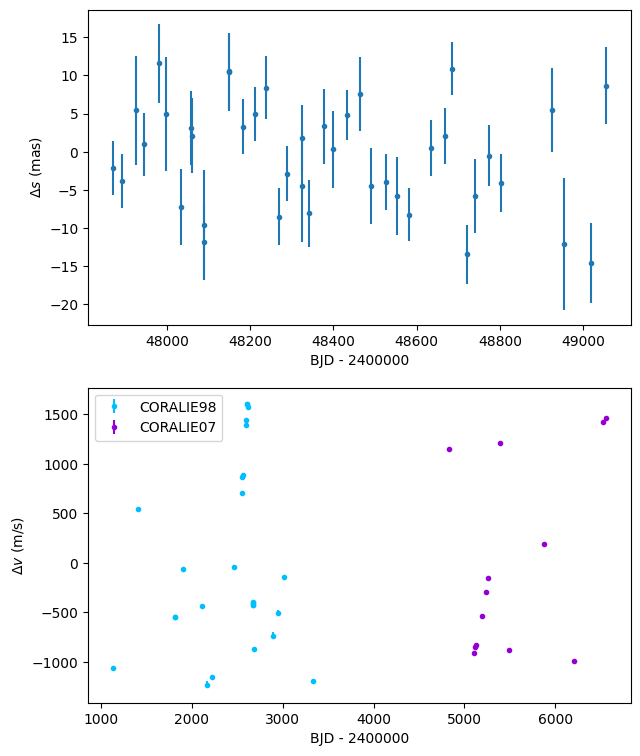

In [40]:
# Create subplot for both astrometry and RV residuals
_, axs = plt.subplots(2, 1, figsize=(7, 9))

# Plot astrometric residuals
ax = axs[0]
astro_res = astro_model.residuals()
astro_res_err = np.sqrt(astro_model.cov.A)
ax.errorbar(astro_model.t, astro_res, yerr=astro_res_err, fmt=".", rasterized=True)
ax.set_xlabel(f"BJD - {epoch_bjd}")
ax.set_ylabel("$\\Delta s$ (mas)")

# Plot RV residuals by instrument
ax = axs[1]
rv_res = rv_model.residuals()
rv_res_err = np.sqrt(rv_model.cov.A)
for inst in instruments:
    kinst = rv_data.ins_name == inst
    ax.errorbar(
        rv_model.t[kinst],
        rv_res[kinst],
        yerr=rv_res_err[kinst],
        fmt=".",
        c=default_inst_color.get(inst, None),
        rasterized=True,
        label=inst,
    )
ax.set_xlabel(f"BJD - {epoch_bjd}")
ax.set_ylabel("$\\Delta v$ (m/s)")
ax.legend()

## 3. Find Planets

We will use periodograms to identify potential planetary companions in the data. By analyzing the periodograms of the residuals from the astrometry, RV, and joint models, we can estimate the periods of any detected signals.

In [41]:
# Define periodogram parameters for frequency analysis
Pmin = 0.9  # Minimum period in days
Pmax = 50000  # Maximum period in days
nfreq = 50000  # Number of frequency steps
nu0 = 2 * np.pi / Pmax  # Initial frequency
dnu = (2 * np.pi / Pmin - nu0) / (nfreq - 1)  # Frequency step size

Text(0.5, 0, 'Period (d)')

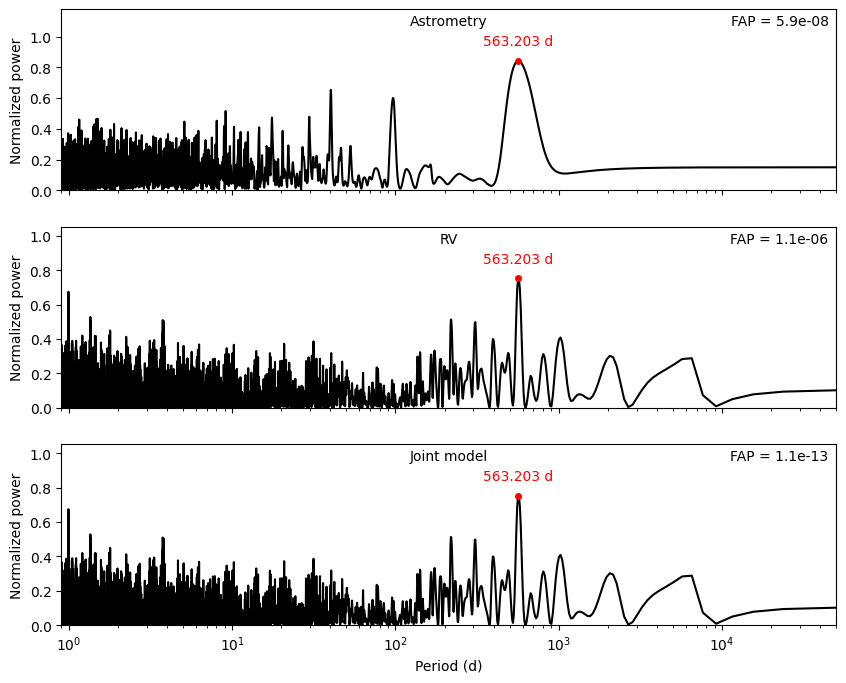

In [42]:
# Compute and plot periodograms for signal detection

# Setup subplots for periodogram analysis
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 8))
models = [astro_model, rv_model, full_model]
model_titles = ["Astrometry", "RV", "Joint model"]
Pguess = []  # Store estimated periods

# Analyze each model's periodogram
for idx, model in enumerate(models):
    ax = axs[idx]

    # Calculate periodogram
    nu, power = model.periodogram(nu0, dnu, nfreq)
    P = 2 * np.pi / nu  # Convert frequency to period

    # Compute False Alarm Probability (FAP)
    max_power_idx = np.argmax(power)
    fap_level = model.fap(power[max_power_idx], nu.max())

    # Plot periodogram
    ax.plot(P, power, "k", lw=1.5, rasterized=True)
    ax.plot(P[max_power_idx], power[max_power_idx], "or", ms=4)
    ax.set_xscale("log")
    ax.set_xlim(Pmin, Pmax)
    ax.set_ylim(0, 1.4 * power.max())
    ax.set_ylabel("Normalized power")

    # Annotate the detected peak period
    ax.text(
        P[max_power_idx],
        power[max_power_idx] * 1.15,
        f"{P[max_power_idx]:.3f} d",
        horizontalalignment="right"
        if P[max_power_idx] > Pmax / 10
        else "left"
        if P[max_power_idx] < Pmin * 10
        else "center",
        verticalalignment="center",
        color="r",
    )

    # Display FAP level
    ax.text(
        0.99,
        0.97,
        f"FAP = {fap_level:.2g}",
        transform=ax.transAxes,
        horizontalalignment="right",
        verticalalignment="top",
    )

    # Display model type
    ax.text(
        0.5,
        0.97,
        model_titles[idx],
        transform=ax.transAxes,
        horizontalalignment="center",
        verticalalignment="top",
    )

    Pguess.append(P[max_power_idx])  # Store estimated period

ax.set_xlabel("Period (d)")

A clear signal is present at 563 days, and we can see that the FAP is many orders of magnitude lower in the Joint Model than any of the previous two models with only astrometry or only RV.

### Now we will add a keplerian to the models and fit again

In [43]:
# Backup current model parameters
param_backup = full_model.fit_param
value_backup = full_model.get_param(param_backup)
all_parameters = {}

### Adding a keplerian using astrometry alone ###
print("Adding keplerian using astrometry alone")
astro_model.add_keplerian_from_period(Pguess[0])
astro_model.set_keplerian_param(
    f"{astro_model.nkep - 1}", param=["P", phase, amp, "e", "w", "i", "bigw"]
)
# Add jitter as a free parameter
astro_model.set_param(default_hip_jitter + 0.01, "cov.jit.sig")
astro_model.fit_param += ["cov.jit.sig"]


# Fit and show astrometric parameters
astro_model.fit()
astro_model.show_param()

print("Log-likelihood (Astro):", astro_model.loglike())

Adding keplerian using astrometry alone
Parameter                        Value     Error       
lin.plx                      -0.006778  ±  nan         
lin.delta                          218  ±  161         
lin.alpha                          162  ±  146         
lin.mud                          -1.60  ±  1.22        
lin.mua                          -1.17  ±  1.10        
cov.jit.sig                   0.000010  ±  nan         
kep.0.P                     560.994410  ±  nan         
kep.0.Marg0 [deg]           176.538169  ±  nan         
kep.0.as                   1576.106428  ±  nan         
kep.0.e                       0.548149  ±  nan         
kep.0.w [deg]                    111.3  ±  20.5        
kep.0.i [deg]                11.278645  ±  nan         
kep.0.bigw [deg]                 299.9  ±  20.4        
Log-likelihood (Astro): -451.229545530089


In [44]:
### Adding a planet using RV data alone ###
print("Resetting model and adding planet using RV data alone")
astro_model.rm_keplerian(f"{astro_model.nkep - 1}")
astro_model.keplerian.uid -= 1
full_model.fit_param = param_backup
full_model.set_param(value_backup)

# Add keplerian from periodogram period and fit orbital parameters
rv_model.add_keplerian_from_period(Pguess[1])
rv_model.set_keplerian_param(f"{rv_model.nkep - 1}", param=["P", phase, amp, "e", "w"])
# Add jitter as a free parameter
for inst in instruments:
    rv_model.set_param(default_inst_jitter[inst], f"cov.jit_{inst}.sig")
rv_model.fit_param += [f"cov.jit_{inst}.sig" for inst in instruments]

# Fit and show RV parameters
rv_model.fit()
rv_model.show_param()

print("Log-likelihood (RV):", rv_model.loglike())

Resetting model and adding planet using RV data alone
Parameter                        Value     Error       
lin.offset_inst_CORALIE98     34962.30  ±  5.13        
lin.offset_inst_CORALIE07     34949.80  ±  2.95        
cov.jit_CORALIE98.sig            21.75  ±  3.72        
cov.jit_CORALIE07.sig             9.00  ±  2.30        
kep.0.P                       561.7064  ±  0.0726      
kep.0.Marg0 [deg]              161.742  ±  0.436       
kep.0.as                      0.061207  ±  0.000214    
kep.0.e                        0.52764  ±  0.00247     
kep.0.w [deg]                   51.802  ±  0.444       
Log-likelihood (RV): -168.47511796952148


In [45]:
### Adding a planet using combined astrometry and RV data ###
print("Resetting model and adding planet using astro + RV")
# Remove RV keplerian and reset model
rv_model.rm_keplerian("0")
rv_model.keplerian.uid -= 1
full_model.fit_param = param_backup
full_model.set_param(value_backup)

# Add keplerian from periodogram period and fit orbital parameters
full_model.add_keplerian_from_period(Pguess[2])
full_model.set_keplerian_param(
    f"{full_model.nkep - 1}", param=["P", phase, amp, "e", "w", "i", "bigw"]
)
# Add jitter as a free parameter
astro_model.set_param(default_hip_jitter + 0.01, "cov.jit.sig")
astro_model.fit_param += ["cov.jit.sig"]
for inst in instruments:
    rv_model.set_param(default_inst_jitter[inst], f"cov.jit_{inst}.sig")
rv_model.fit_param += [f"cov.jit_{inst}.sig" for inst in instruments]

# Fit and show combined parameters
full_model.fit()
full_model.fit()
full_model.fit()
full_model.show_param()

print("Log-likelihood (Full):", full_model.loglike())

Resetting model and adding planet using astro + RV
Parameter                        Value     Error       
astro.lin.plx                   0.1942  ±  0.0171      
astro.lin.delta                    294  ±  165         
astro.lin.alpha                    165  ±  148         
astro.lin.mud                    -2.17  ±  1.24        
astro.lin.mua                    -1.20  ±  1.12        
astro.cov.jit.sig                0.000  ±  0.748       
rv.lin.offset_inst_CORALIE98     34962.29  ±  5.13        
rv.lin.offset_inst_CORALIE07     34949.81  ±  2.95        
kep.0.P                       561.7082  ±  0.0715      
kep.0.Marg0 [deg]              161.752  ±  0.428       
kep.0.as                     55.247935  ±  nan         
kep.0.e                        0.52761  ±  0.00244     
kep.0.w [deg]                   51.804  ±  0.440       
kep.0.i [deg]                 0.063476  ±  nan         
kep.0.bigw [deg]                353.92  ±  6.81        
rv.cov.jit_CORALIE98.sig         21.74  ±  3.71

### Compute Planetary Mass

Using the parameters obtained from the joint model, we will compute the mass of the detected planetary companion. This involves calculating the mean motion, semi-major axis, and iteratively solving for the planetary mass.

In [46]:
# Define astronomical constants
GmSun_AU3d2 = 0.0002959212  # Gravitational constant times mass of the Sun in AU^3/day^2
mJS = 0.000954791898312  # Mass of Jupiter in solar masses

In [47]:
# Get orbital period from the RV model
P = rv_model.get_param("kep.0.P")

# Calculate mean motion (n = 2π/P)
n = 2 * np.pi / P

# Create a deep copy of the RV model to avoid modifying the original model
copy_rv_model = deepcopy(rv_model)
# Change the set of keplerian parameters
copy_rv_model.set_keplerian_param("0", param=["P", "M0", "K", "e", "omega"])
K = copy_rv_model.get_param("kep.0.K")  # RV semi-amplitude in m/s
e = copy_rv_model.get_param("kep.0.e")  # Eccentricity

# Calculate minimum mass (M * sin i) using the RV-only model
# Using the mass function formula:
# f(m) = K^3 * P / (2*pi*G) * (1-e^2)^(3/2)

# Convert K from m/s to AU/day
K_AU_per_day = K * 86400 / (149597870700)  # Convert m/s to AU/day

# Calculate mass function in solar masses
mf = (K_AU_per_day**3 * P) / (2 * np.pi * GmSun_AU3d2) * (1 - e**2) ** (3 / 2)

# Then calculate minimum mass iteratively
mp_sini = 0
for _ in range(10):
    mp_sini = (mf * (ms + mp_sini) ** 2) ** (1 / 3)

# Print result in Jupiter masses
print(f"Minimum planetary mass (M * sin i): {mp_sini / mJS:.3f} M_Jup")

Minimum planetary mass (M * sin i): 49.949 M_Jup


The minimum mass of the companion using only the RV fit is of close to 50 Jupiter masses.
However, if we take into account the full astrometric+RV solution we will see that the result is quite different.

In [48]:
# Get orbital period from full model
P = full_model.get_param("kep.0.P")

# Calculate mean motion (n = 2π/P)
n = 2 * np.pi / P

# Get semi-major axis in AU from model
a = full_model.get_param("kep.0.as")

# Calculate mass factor using Kepler's third law
# (n^2 * a^3) / G = (M* + Mp)^2
mass_factor = n**2 * a**3 / GmSun_AU3d2

# Iteratively solve for planetary mass
# Starting with mp = 0, iterate until convergence
mp = 0
for _ in range(10):
    mp = (mass_factor * (ms + mp) ** 2) ** (1 / 3)

# Print result in Jupiter masses
print(f"Companion mass: {mp / mJS:.3f} M_Jup")
print(f"Companion mass: {mp:.3f} M_Sun")

Companion mass: 61582097.227 M_Jup
Companion mass: 58798.088 M_Sun


With a mass of ~540 $M_{Jup}$, the companion is classified as a star, specifically an M dwarf. This classification is due to the high inclination of 173 degrees, which significantly affects the observed mass. The high inclination indicates that we are viewing the system nearly face-on, leading to a larger inferred mass for the companion than the one we get from RV alone.

## 4. Plot Orbits

We will visualize the fitted orbits and residuals for both the astrometry and RV data. This includes plotting the astrometric orbit, RV time series, and phase-folded RV curve.

In [49]:
# Extract residuals and errors for plotting
astro_res = astro_model.residuals()  # Get astrometric residuals
astro_err = np.sqrt(astro_model.cov.A)  # Get astrometric measurement errors
plx = astro_model.get_param("lin.plx")  # Get parallax value

rv_res = rv_model.residuals()  # Get RV residuals
rv_err = np.sqrt(rv_model.cov.A)  # Get RV measurement errors

# Define time range for plotting
Tmin = rv_model.t[0]
Tmax = rv_model.t[-1]
dT = Tmax - Tmin

# Get Keplerian model parameters for planet 0
kpla = 0  # Planet index
kep = full_model.keplerian["0"]  # Get Keplerian model for this planet
parbak = kep.get_param()  # Backup current parameters

# Set parameters for Keplerian model
param = ["P", "Tp", "as", "e", "w", "i", "bigw"]  # Parameter names to use
full_model.set_keplerian_param("0", param=param)  # Set parameters in model

# Get orbital period
P = full_model.get_param("kep.0.P")

# Create smooth time array for model orbit
# Create evenly spaced time points over one orbit
astro_tsmooth = np.linspace(-P / 2, P / 2, 1000)

# Calculate model predictions for position (declination and right ascension)
astro_d_mod, astro_a_mod = kep.astro(astro_tsmooth)

# Convert positions to angular units using parallax
astro_d_mod *= plx
astro_a_mod *= plx

# Get model predictions at observation times
d, a = kep.astro(astro_model.t)
d *= plx
a *= plx

# Calculate residual positions by combining model and residuals
astro_d_res = d + astro_res * astro_data["CTH"]  # Declination residuals
astro_a_res = a + astro_res * astro_data["STH"]  # Right ascension residuals

# Calculate position uncertainties
astro_d_err = astro_err * astro_data["CTH"]  # Declination uncertainties
astro_a_err = astro_err * astro_data["STH"]  # Right ascension uncertainties

### Astrometric Orbit

We will plot the astrometric orbit, showing the measured positions, model predictions, and residuals.

(-22.337811360030884, 11.454332837569051)

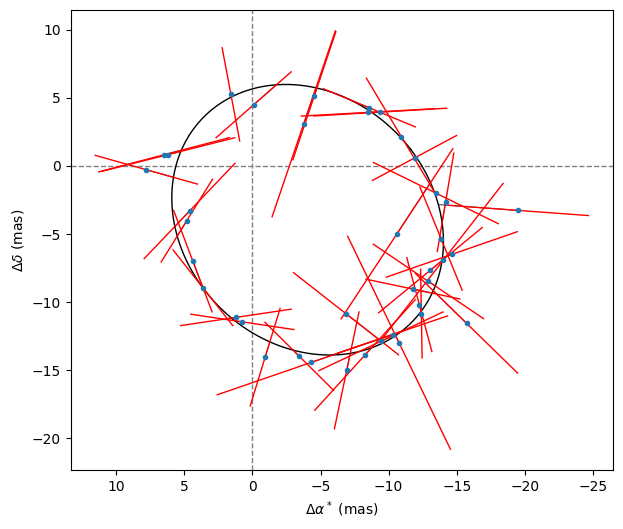

In [50]:
# Create figure for astrometric orbit plot
plt.figure(figsize=(7, 7))

# Plot connecting lines between measured and model positions
for k in range(len(a)):
    plt.plot(
        # X coordinates: measured to model position (right ascension)
        [
            astro_a_res[k],
            a[k],
        ],
        # Y coordinates: measured to model position (declination)
        [
            astro_d_res[k],
            d[k],
        ],
        "k",  # Black color
        lw=0.75,  # Line width
        alpha=0.75,  # Transparency
        zorder=0,  # Draw below other elements
    )

# Plot error bars for each measurement
for k in range(len(a)):
    plt.plot(
        [
            astro_a_res[k] - astro_a_err[k],
            astro_a_res[k] + astro_a_err[k],
        ],  # X error bars
        [
            astro_d_res[k] - astro_d_err[k],
            astro_d_res[k] + astro_d_err[k],
        ],  # Y error bars
        "r-",  # Red color
        lw=1,  # Line width
        zorder=2,  # Draw above connecting lines
    )

# Plot the model orbit
plt.plot(astro_a_mod, astro_d_mod, "k-", lw=1, rasterized=True, zorder=1)

# Plot the measured positions
plt.plot(astro_a_res, astro_d_res, ".", rasterized=True, zorder=3)

# Set axis labels
plt.xlabel("$\\Delta \\alpha^*$ (mas)")
plt.ylabel("$\\Delta \\delta$ (mas)")

# Invert x-axis (standard for astrometric plots)
plt.gca().invert_xaxis()

# Set equal aspect ratio
plt.gca().set_aspect("equal", adjustable="box")

# Get current axis limits
xlim = plt.xlim()
ylim = plt.ylim()

# Add zero reference lines
plt.plot(xlim, [0, 0], "--", c="gray", lw=1, zorder=-10)  # Horizontal line
plt.plot([0, 0], ylim, "--", c="gray", lw=1, zorder=-10)  # Vertical line

# Restore axis limits
plt.xlim(xlim)
plt.ylim(ylim)

### RV Orbit on the Timeseries

We will plot the RV orbit on the timeseries, showing the model predictions and residuals for each instrument.

Text(0, 0.5, '$\\Delta v$ (m/s)')

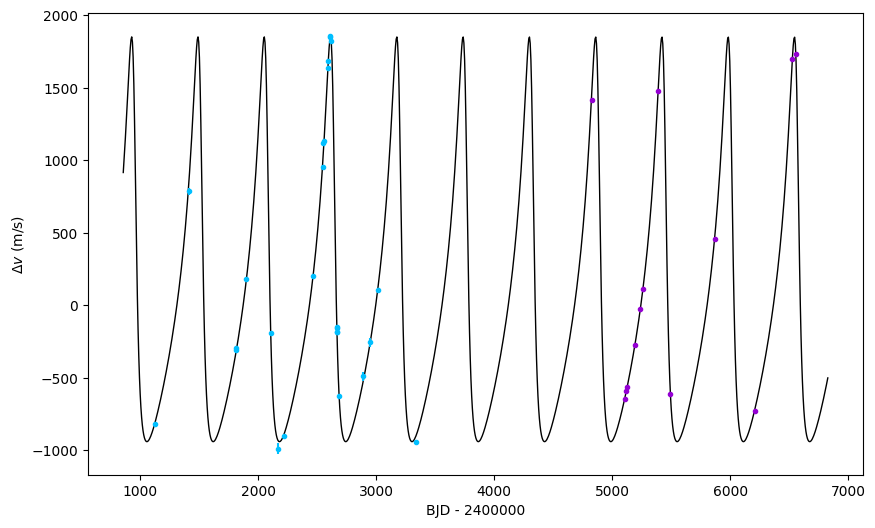

In [51]:
# Create smooth time array for plotting
rv_tsmooth = np.linspace(Tmin - dT / 20, Tmax + dT / 20, 1000)

# Calculate RV model predictions for smooth time array
rv_mod = kep.rv(rv_tsmooth)

# Get RV model predictions + residuals for actual data points
rv_kep_res = kep.rv(rv_model.t) + rv_res

# Create figure for RV time series plot
plt.figure(figsize=(10, 6))

# Plot the smooth RV model curve
plt.plot(rv_tsmooth, rv_mod, "k-", lw=1, rasterized=True)

# Plot data points for each instrument with error bars
for inst in instruments:
    # Select data points for current instrument
    kinst = rv_data.ins_name == inst

    # Plot points with error bars using instrument-specific colors
    plt.errorbar(
        rv_model.t[kinst],
        rv_kep_res[kinst],
        yerr=rv_res_err[kinst],
        fmt=".",
        c=default_inst_color.get(inst, None),
        rasterized=True,
    )

# Set axis labels
plt.xlabel(f"BJD - {epoch_bjd}")
plt.ylabel("$\\Delta v$ (m/s)")

### Phase-fold

We will create a phase-folded plot of the RV data, showing the model curve and residuals as a function of the mean anomaly.

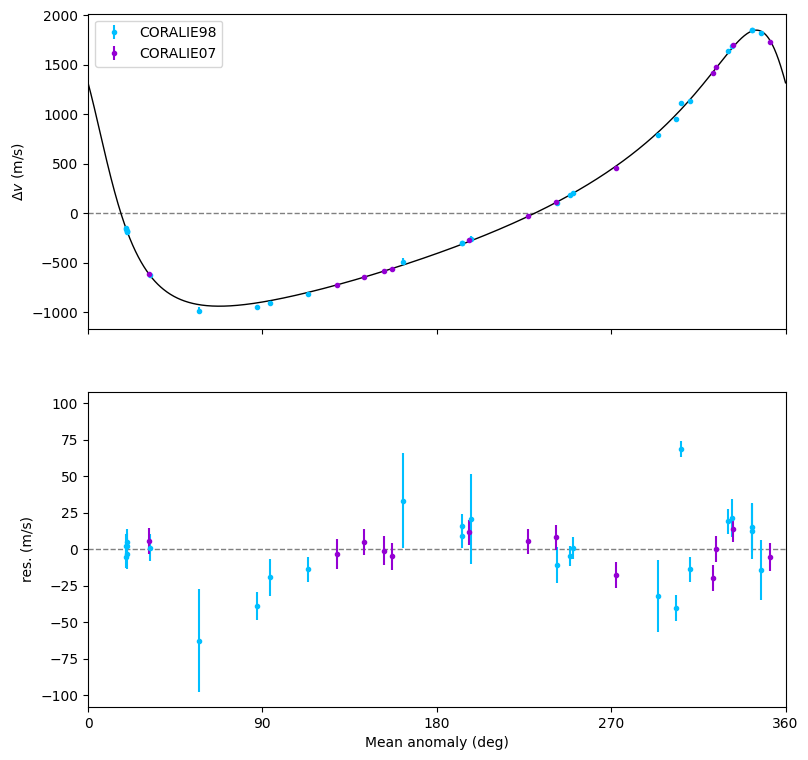

In [52]:
# Get the epoch of periapsis passage and period from the model
Tp = full_model.get_param("kep.0.Tp")
M_mod = np.linspace(0, 360, 1000)  # Create mean anomaly array for phase folding

# Calculate time array based on mean anomaly
rv_tsmooth = Tp + M_mod * P / 360

# Get RV model predictions and residuals
rv_mod = kep.rv(rv_tsmooth)  # Model RV curve
rv_kep_res = kep.rv(rv_model.t) + rv_res  # RV data with residuals

# Calculate mean anomaly for the observations
M_res = (360 * (rv_model.t - Tp) / P) % 360

# Create subplot with two panels
_, axs = plt.subplots(2, 1, sharex=True, figsize=(9, 9))

# Top panel: Phase-folded RV curve
ax = axs[0]
ax.plot([0, 360], [0, 0], "--", c="gray", lw=1)  # Zero line
ax.plot(M_mod, rv_mod, "k-", lw=1, rasterized=True)  # Model curve

# Plot data points by instrument
for inst in instruments:
    kinst = rv_data.ins_name == inst
    ax.errorbar(
        M_res[kinst],
        rv_kep_res[kinst],
        yerr=rv_res_err[kinst],
        fmt=".",
        c=default_inst_color.get(inst, None),
        label=inst,
        rasterized=True,
    )
ax.set_ylabel("$\\Delta v$ (m/s)")
ax.legend()

# Bottom panel: Residuals
ax = axs[1]
ax.plot([0, 360], [0, 0], "--", c="gray", lw=1)  # Zero line

# Plot residuals by instrument
for inst in instruments:
    kinst = rv_data.ins_name == inst
    ax.errorbar(
        M_res[kinst],
        rv_res[kinst],
        yerr=rv_res_err[kinst],
        fmt=".",
        c=default_inst_color.get(inst, None),
        rasterized=True,
    )

# Set axis labels and limits
ax.set_xlim(0, 360)
ylim = 1.1 * np.max(abs(rv_res) + rv_res_err)
ax.set_ylim(-ylim, ylim)
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_xlabel("Mean anomaly (deg)")
ax.set_ylabel("res. (m/s)")

# Restore original model parameters
full_model.set_keplerian_param("0", param=parbak)